# Oil Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/OilFlows.ipynb). 

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
!pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

## Call the Voyages API
The Voyages API retrieves information about vessel voyages.

In [ ]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import Vessel, VesselFilter
from signal_ocean.voyages import VesselType, VesselTypeFilter
from signal_ocean.voyages import VesselClass, VesselClassFilter
import pandas as pd
from datetime import date, timedelta, datetime
import plotly.express as px

In [ ]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

Get vessel class id for VLCCsTankers

In [2]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Tanker'].head(7)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
11,84,VLCC,1,Tanker
12,85,Suezmax,1,Tanker
13,86,Aframax,1,Tanker
14,87,Panamax,1,Tanker
15,88,MR2,1,Tanker
16,89,MR1,1,Tanker
17,90,Small,1,Tanker


### Get voyages for VLCCs

For VLCCs we will use (vessel_class_id = 84) when calling the API

In [3]:
voyages = api.get_voyages_condensed(vessel_class_id=84, date_from=datetime.strptime("2019-09-01", "%Y-%m-%d"))
voyages = pd.DataFrame([v.__dict__ for v in voyages])
voyages.tail()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
12112,9929663,1,1,84,1,NaN,False,None,I9783BF54VED9D1A000,1,...,2022-07-19 07:47:37+00:00,165.0,Malaysia,None,Singapore / Malaysia,True,False,True,False,False
12113,9929663,2,1,84,1,NaN,False,None,I9783BF54VEDA484700,2,...,2022-10-08 23:00:00+00:00,173.0,Netherlands,None,Continent,False,False,True,False,False
12114,9931329,1,1,84,1,NaN,False,None,I978A4154VED9F92D00,2,...,2022-10-03 00:43:51.662000+00:00,129.0,"Korea, Republic of",None,Korea,True,False,False,False,True
12115,9933535,1,1,84,1,5972.0,False,None,I9792DF54VEDA976100,2,...,NaT,NaN,None,None,None,True,False,False,False,True
12116,9933640,1,1,84,1,NaN,False,None,I97934854VEDA484700,2,...,NaT,NaN,None,None,None,True,False,False,False,True


Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [4]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]

## Examine US VLCC Dirty Exports
Group by origin and destination (first load, last discharge), and use first_load_sailing_date as date of export

In [5]:
dirty_exports_country_level = voyages[(voyages['first_load_sailing_date']>"2020-01-01")&(voyages['cargo_group']=='Dirty')] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})

In [6]:
dirty_exports_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Algeria,Netherlands,2020-05-01,240000.0
1,Angola,Angola,2020-02-01,246000.0
2,Angola,Caribs,2021-10-01,225000.0
3,Angola,China,2020-01-01,3080000.0
4,Angola,China,2020-02-01,3367000.0


Drop intra country flows

In [7]:
dirty_exports_country_level = dirty_exports_country_level[dirty_exports_country_level['first_load_country_name']!=dirty_exports_country_level['last_discharge_country_name']]

* Keep only US exports
* Aggregate all exports monthly
* Drop unnecessary columns 

In [8]:
us_dirty_exports = dirty_exports_country_level[(dirty_exports_country_level['first_load_country_name']=='United States')].copy()

us_dirty_exports['TotalExports'] = us_dirty_exports['quantity'].groupby(us_dirty_exports['Date']).transform('sum')
us_dirty_exports.drop_duplicates(subset=['Date'], keep='last', inplace = True)
us_dirty_exports.drop(['last_discharge_country_name', 'quantity'], axis=1, inplace = True)
us_dirty_exports.head()

,first_load_country_name,Date,TotalExports
5556,United States,2020-01-01,4472000.0
5557,United States,2020-02-01,4249000.0
5588,United States,2020-03-01,5095000.0
5589,United States,2020-04-01,4234000.0
5590,United States,2020-05-01,5887000.0


### Plot US VLCC Dirty exports

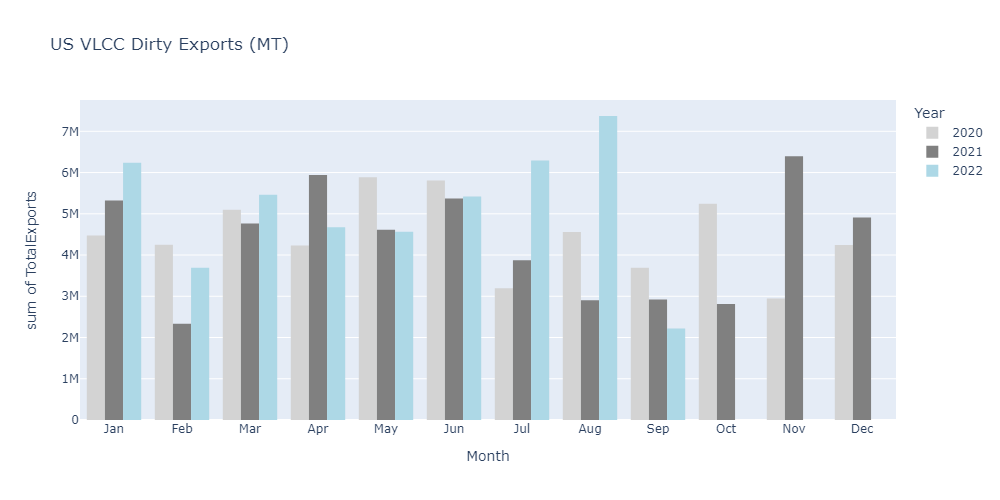

In [9]:
us_dirty_exports['Year'] = us_dirty_exports['Date'].apply(lambda date : date.year)
us_dirty_exports['Month'] = us_dirty_exports['Date'].apply(lambda date : date.month)
us_dirty_exports.sort_values(['Month', 'Year'], inplace = True)
us_dirty_exports['Month'] = us_dirty_exports['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(us_dirty_exports, x="Month", y="TotalExports", color='Year',
             barmode='group', height=500, width=1000,
             title='US VLCC Dirty Exports (MT)',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

<h3>Examine China VLCC Dirty Imports</h3>
Convert Timestamp to datetime, drop uncompleted voyages (with last_discharge_arrival_date in the future)

In [10]:
voyages['last_discharge_arrival_date'] = voyages['last_discharge_arrival_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['last_discharge_arrival_date']<datetime.now()]

Group by origin and destination (first load, last discharge), and use last_discharge_arrival_date as date of import

In [11]:
dirty_imports_country_level = voyages[(voyages['last_discharge_arrival_date']>"2020-01-01")&(voyages['cargo_group']=='Dirty')] \
    .set_index('last_discharge_arrival_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'last_discharge_arrival_date': 'Date'})

Drop intra country flows

In [12]:
dirty_imports_country_level = dirty_imports_country_level[dirty_imports_country_level['first_load_country_name']!=dirty_imports_country_level['last_discharge_country_name']]
dirty_imports_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Algeria,Netherlands,2020-05-01,240000.0
2,Angola,Caribs,2021-10-01,225000.0
3,Angola,China,2020-01-01,3132000.0
4,Angola,China,2020-02-01,3346000.0
5,Angola,China,2020-03-01,3356000.0


* Keep only China imports
* Aggregate all exports monthly
* Drop unnecessary columns

In [13]:
china_dirty_imports = dirty_imports_country_level[(dirty_imports_country_level['last_discharge_country_name']=='China')].copy()

china_dirty_imports['TotalImports'] = china_dirty_imports['quantity'].groupby(china_dirty_imports['Date']).transform('sum')
china_dirty_imports.drop_duplicates(subset=['Date'], keep='last', inplace = True)
china_dirty_imports.drop(['first_load_country_name', 'quantity'], axis=1, inplace = True)
china_dirty_imports.head()

,last_discharge_country_name,Date,TotalImports
5124,China,2020-01-01,29719000.0
5779,China,2020-02-01,28796000.0
5780,China,2020-03-01,30644000.0
5781,China,2020-04-01,26846000.0
5782,China,2020-05-01,36056000.0


### Plot China VLCC Dirty Imports

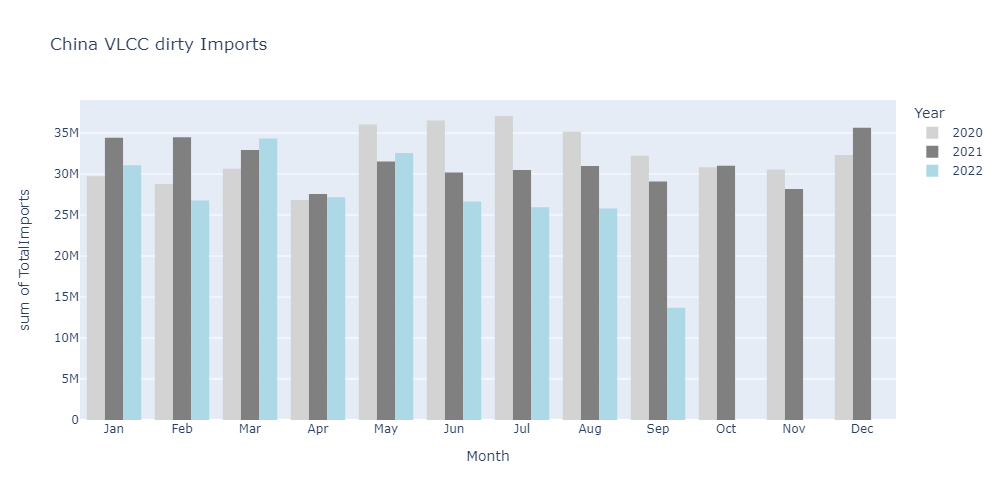

In [14]:
china_dirty_imports['Year'] = china_dirty_imports['Date'].apply(lambda date : date.year)
china_dirty_imports['Month'] = china_dirty_imports['Date'].apply(lambda date : date.month)
china_dirty_imports.sort_values(['Month', 'Year'], inplace = True)
china_dirty_imports['Month'] = china_dirty_imports['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(china_dirty_imports, x="Month", y="TotalImports", color='Year',
             barmode='group', height=500, width=1000,
             title='China VLCC dirty Imports',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Build your custom Flows - US Clean Exports to specific countries by Panamax and MR2

Get vessel class ids for Tanker vessel classes

In [15]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Tanker'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
11,84,VLCC,1,Tanker
12,85,Suezmax,1,Tanker
13,86,Aframax,1,Tanker
14,87,Panamax,1,Tanker
15,88,MR2,1,Tanker
16,89,MR1,1,Tanker
17,90,Small,1,Tanker


### Select the vessel classes of interest
Get voyages for selected vessel classes (Panamax and MR2) after a given date

In [16]:
vessel_class_ids = (87, 88) # Get only voyages for Aframax, Panamax and MR2
date_from = datetime.strptime("2021-09-01", "%Y-%m-%d")

voyages = []
for vessel_class_id in vessel_class_ids:    
    voyages.append(api.get_voyages_condensed(vessel_class_id=vessel_class_id, date_from=date_from))
    
voyages = pd.DataFrame([v.__dict__ for vc in voyages for v in vc])
voyages.tail(5)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
25903,9935909,2,1,88,1,NaN,False,None,I979C2558VEDA976100,2,...,NaT,NaN,None,None,None,False,False,False,False,True
25904,9941910,1,1,88,1,886.0,False,None,I97B39658VEDA484700,2,...,2022-09-18 00:46:34.184000+00:00,205.0,Singapore,None,Singapore / Malaysia,True,False,False,False,False
25905,9942304,1,1,88,1,270.0,False,None,I97B52058VED9F92D00,1,...,2022-09-01 15:57:48+00:00,173.0,Netherlands,None,Continent,True,False,False,False,False
25906,9942304,2,1,88,1,270.0,False,None,I97B52058VEDA976100,2,...,2022-09-20 23:00:00+00:00,66.0,Denmark,None,Baltic Sea Low,False,False,False,False,False
25907,9942304,3,1,88,1,270.0,False,None,I97B52058VEDAB1BF00,3,...,NaT,NaN,None,None,None,False,False,False,False,True


Date of flows will be based on the export date
* Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [17]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]
voyages.head()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
0,9063108,191,1,87,1,356.0,False,None,I8A4AC4VED8D72300,1,...,2021-10-28 03:57:47+00:00,55.0,China,None,South China,False,False,False,False,True
1,9063108,192,1,87,1,356.0,False,None,I8A4AC4VED90BDF00,1,...,2021-12-03 07:58:12+00:00,55.0,China,None,South China,True,False,False,False,True
2,9063108,193,1,87,1,356.0,False,None,I8A4AC4VED9336C00,1,...,2021-12-19 23:54:26+00:00,55.0,China,None,South China,False,False,False,False,True
3,9063108,194,1,87,1,356.0,False,None,I8A4AC4VED94DCA00,1,...,2022-01-07 07:53:53+00:00,55.0,China,None,South China,False,False,False,False,True
4,9063108,195,1,87,1,356.0,False,None,I8A4AC4VED95AF900,1,...,2022-01-22 23:58:57+00:00,55.0,China,None,South China,False,False,False,False,True


### Select the cargo types of interest
Examine different cargo types under the "Clean" cargo group

In [18]:
voyages[voyages['cargo_group']=='Clean'].drop_duplicates(subset=['cargo_group', 'cargo_type'], keep='last')[['cargo_group', 'cargo_type']].head()

,cargo_group,cargo_type
8952,Clean,Middle Product
9415,Clean,High Speed Diesel
10125,Clean,DMA
10872,Clean,Heavy Vacuum Oil
11960,Clean,AVGAS


In [19]:
voyages[(voyages['first_load_country_name']=='United States')&(voyages['cargo_group']=='Clean')]['cargo_type'].value_counts().head(10)

Gasoline                       1305
Diesel                         1059
Ultra Low Sulphur Diesel        335
Gasoil                          313
Naphtha                         279
Unleaded Motor Spirit           234
Jet                             201
Gasoline Blending Component      49
High Sulphur Diesel              18
ETBE                             11
Name: cargo_type, dtype: int64

* Keep cargo types of interest
* Group by origin and destination (first load, last discharge) and cargo type
* Use last_discharge_arrival_date as date of flow

In [20]:
cargo_types_of_interest = ('Gasoline', 'Diesel', 'Ultra Low Sulphur Diesel', 'Gasoil', 'Naphtha', 'Unleaded Motor Spirit', 'Jet')

custom_flows_country_level = voyages[(voyages['first_load_sailing_date']>"2022-01-01")&(voyages['cargo_type'].isin(cargo_types_of_interest))] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name', 'cargo_type'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})
custom_flows_country_level.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
0,Albania,Libya,Ultra Low Sulphur Diesel,2022-05-01,30000.0
1,Algeria,Belgium,Naphtha,2022-01-01,35000.0
2,Algeria,Belgium,Naphtha,2022-02-01,37000.0
3,Algeria,Belgium,Unleaded Motor Spirit,2022-05-01,37000.0
4,Algeria,Brazil,Naphtha,2022-08-01,60000.0


### Select flows of interest
Keep only flows between US and (Mexico, Brazil, Argentina)

In [21]:
import_countries = ('Mexico', 'Brazil', 'Argentina')
custom_flows = custom_flows_country_level[(custom_flows_country_level['first_load_country_name']=='United States')&(custom_flows_country_level['last_discharge_country_name'].isin(import_countries))].copy()
custom_flows.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
6757,United States,Argentina,Diesel,2022-02-01,98000.0
6758,United States,Argentina,Diesel,2022-03-01,0.0
6759,United States,Argentina,Diesel,2022-04-01,143000.0
6760,United States,Argentina,Diesel,2022-05-01,110000.0
6761,United States,Argentina,Diesel,2022-06-01,34000.0


### Plot custom flows - US Clean Exports to specific countries

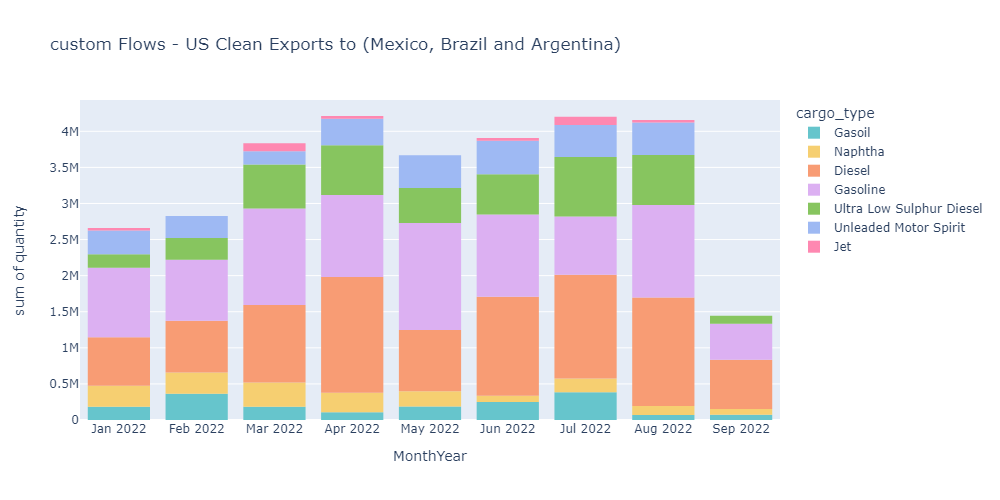

In [26]:
custom_flows['Year'] = custom_flows['Date'].apply(lambda date : date.year)
custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.month)
custom_flows.sort_values(['Year', 'Month'], inplace = True)

custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.strftime("%b"))
custom_flows['Year'] = custom_flows['Date'].apply(lambda date : date.strftime("%Y"))
custom_flows['MonthYear'] = custom_flows['Month'].astype(str) + ' ' + custom_flows['Year'].astype(str)

fig = px.histogram(custom_flows, x="MonthYear", y="quantity", color='cargo_type',
            height=500, width=1000, title='custom Flows - US Clean Exports to (Mexico, Brazil and Argentina)',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(bargap=0.2)
fig.show()